# ANALISI CONSUMI
Lo scopo di questo progetto è di analizzare i consumi di un determinato ufficio locato a Bergamo con l'intento di individuare possibili anomalie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
!pip install holidays
import holidays
# %matplotlib notebook

In [2]:
# Constant
FIG_SIZE = (16, 10)

## Preparazione del Dataset
Tra i dati letti all'interno del file csv, quelli che verranno effettivamente analizzati sono quelli provenienti dai Circuit Breaker 'First floor', 'Second floor' e 'Third floor'.

In [3]:
cb_target = [['CB Third Floor'], ['CB First Floor', 'CB Second Floor']]
cb_flat = sum(cb_target, [])
cb_flat

['CB Third Floor', 'CB First Floor', 'CB Second Floor']

In [4]:
dataset = pd.read_csv('AVGpower-1.csv', sep=';', parse_dates=['DateTime'])
dataset = dataset.astype({'AvgP':'int16', 'AvgT':'float32', 'AvgH':'float32'})
dataset

,DateTime,CbTagName,AvgP,AvgT,AvgH
0,2017-01-01 00:15:00,Bridge,0,0.0,0.000000
1,2017-02-06 00:00:00,CB Second Floor,0,3.5,98.599998
2,2017-02-06 00:00:00,CB First Floor,0,3.5,98.599998
3,2017-02-06 00:00:00,CB Backup A,0,3.5,98.599998
4,2017-02-06 00:00:00,CB Back Up C,0,3.5,98.599998
...,...,...,...,...,...
437559,2019-04-10 15:30:00,CB Backup A,0,18.1,52.599998
437560,2019-04-10 15:30:00,CB First Floor,68,18.1,52.599998
437561,2019-04-10 15:30:00,CB Back Up C,0,18.1,52.599998
437562,2019-04-10 15:30:00,Bridge,0,18.1,52.599998


In [5]:
# Preparazione dataset
train = dataset[dataset['CbTagName']=='CB First Floor'].set_index('DateTime')
d1 = dataset[dataset['CbTagName']=='CB Second Floor'].set_index('DateTime')
d2 = dataset[dataset['CbTagName']=='CB Third Floor'].set_index('DateTime')
train = train.join(d1, lsuffix='', rsuffix='2', how='inner')
train = train.join(d2, lsuffix='1', rsuffix='3', how='inner')
train.drop(columns=['AvgT2', 'AvgT3', 'AvgH2', 'AvgH3', 'CbTagName1', 'CbTagName2', 'CbTagName3'], inplace=True)
train.rename(columns={'AvgT1':'AvgT', 'AvgH1':'AvgH'}, inplace=True)
train['DateTime'] = train.index

## Correzione del Dataset
Dall'analisi dei dati emerge che la frequenza di campionamento è di 15 minuti, tuttavia è stata notata la mancanza di aluni campioni all'interno del dataset:
per risolvere questo problema si è scelto di introdurre dei campioni fittizi per colmare le mancanze.
<br>
Poichè in certi casi i dati mancanti possono essere 'contigui', la scelta di interpolare dei dati non può essere sempre considerata, di conseguenza si è preferito inserire i valori dei campioni che precedono il campione mancante di esattamente una settimana. L'interpolazione dei dati è stata adottata esclusivamente per correggere la prima settimana di campionamento, in quanto anche essa presenta dei dati mancanti ma molto sparsi, condizione apprezzabile per applicare l'interpolazione: quest'ultima è fondamentale, in quanto non sarebbe possibile colmare le mancanze successive, poichè si rischierebbe di copiare un valore inesistente. 


In [6]:
# aggiunta punti mancanti
new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-08', end='2017-02-15', freq='15Min'):
    if date not in train['DateTime']:
        print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)

train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')
train.interpolate(inplace=True)
train['DateTime'] = train.index

new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-15', end=train['DateTime'].max(), freq='15Min'):
    if date not in train['DateTime']:
        #print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)
train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')

train.sort_index(inplace=True)

for i in range(672, len(train)):
    if np.isnan(train.iloc[i].AvgP1):
        train.iloc[i] = train.iloc[i-672]
train['DateTime'] = train.index

2017-02-08 02:15:00
2017-02-12 00:00:00
2017-02-12 18:00:00
2017-02-12 18:30:00
2017-02-12 19:15:00
2017-02-12 19:45:00
2017-02-12 21:00:00
2017-02-13 04:15:00
2017-02-13 05:45:00
2017-02-13 06:15:00
2017-02-13 06:45:00
2017-02-13 07:15:00
2017-02-13 08:15:00
2017-02-13 08:45:00
2017-02-13 09:15:00


In [7]:
# giorni di vacanza
holidays_it = holidays.Italy()
train['holidays'] = train['DateTime'].apply(lambda x: x in holidays_it).astype('int8')
# giorno della settimana
train['dayofweek'] = train['DateTime'].dt.dayofweek
# salvataggio dataset
train.to_pickle('train1.pkl')

## Dati terzo piano
I dati del terzo piano non sono particolarmente significativi per poter individuare anomalie all'interno dei giorni festivi e lavorativi, in quanto gli impianti di riscaldamento e di raffreddamento sono accesi indipendentemente dal tipo di giorno.
I dati fanno notare come i consumi legati al riscaldamento dipendano per lo più dalle stagioni come si può notare dal grafico:
mediamente i consumi più bassi si hanno durante la primavera poichè le temperature sono più miti.
<br>
Per questo motivo si è scelto di studiare più nel dettaglio l'andamento dei consumi elettrici del **secondo piano** dove vengono registrati i consumi relativi alla luce.

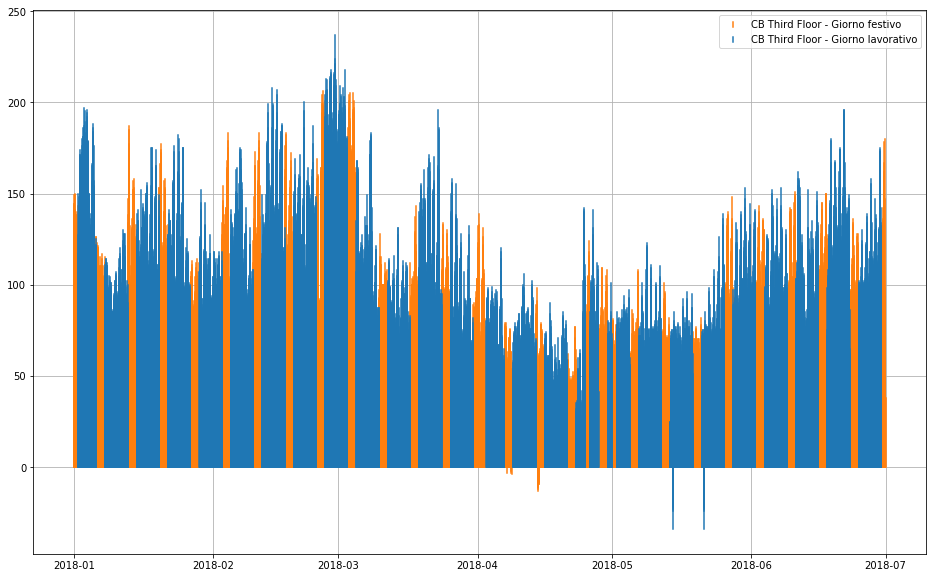

In [8]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2018]
curr_dataset = curr_dataset[(1 <= curr_dataset['DateTime'].dt.month)&(curr_dataset['DateTime'].dt.month <= 6)]
#curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.day < 12]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


# Dati anomali

All'interno di questo dataset sono state riscontrate alcune anomalie:
- 24/04/2017 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 14/08/2017 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 16/08/2017 e 17/08/2017 giorni lavorativi con bassi consumi: si presume che siano giorni di vacanza di ferragosto.
- 27/12/2017 28/12/2017 29/12/2017 giorni lavorativi con consumi bassi: si presume siano giorni di vacanze natalizie.
- 01/01/2018 fino a 08/01/2018 giorni lavorativi con consumi medio bassi: si presume che alcuni dipendenti abbiano preso ferie tra capodanno e l'epifania.
- 30/04/2018 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 15/08/2018 giorno festivo con consumi elevati: i dati di questo giorno in realtà sono quelli del 08/08/2018 che è un giorno lavorativo in quanto i dati reali del 15/08/2018 sono mancanti.
- 13/08/2018 e 14/08/2018 giorni lavorativi con bassi consumi: essendo giorni precedenti a quello di ferragosto si presume che i dipendenti abbiano preso ferie per le vacanze di ferragosto. 
- 02/11/2018 giorno lavorativo con consumi bassi: i due giorni successivi sono weekend mentre il giorno precedente è un festivo, si presume che questo giorno sia un ponte.
- 26/12/2018 giorno festivo con picchi di consumi elevati: è difficile dare una spigazione a questa anomalia.

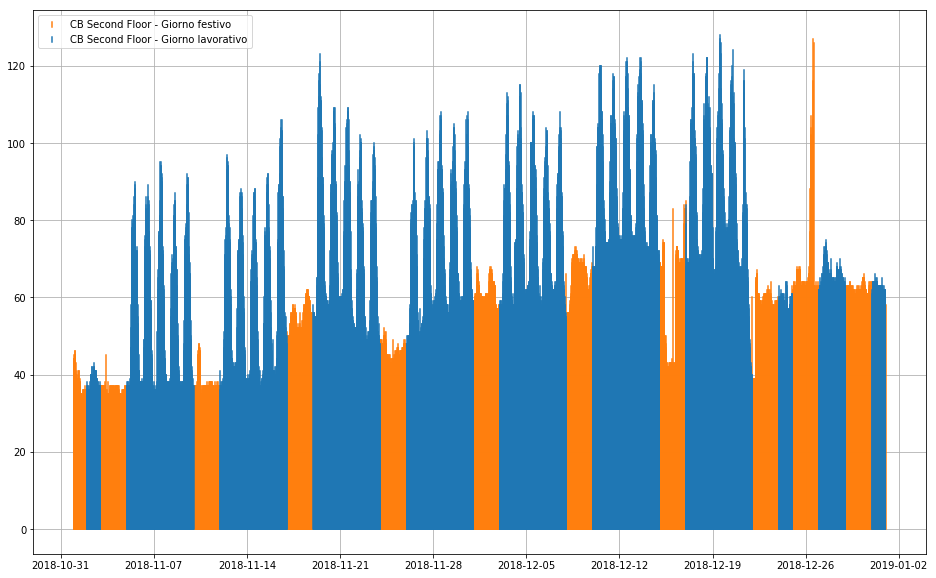

In [9]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[('2018-11-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2019-01-01')]
# curr_dataset = curr_dataset[('2017-08-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2017-09-01')]

#curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.day < 12]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP2'], label='CB Second Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP2'], label='CB Second Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


# Anomalie Terzo piano
Nonostante il terzo piano non sia particolarmente significativo, si è notata la presenza di dati anomali, ovvero potenze **negative** che offrono un interessante spunto di riflessione.

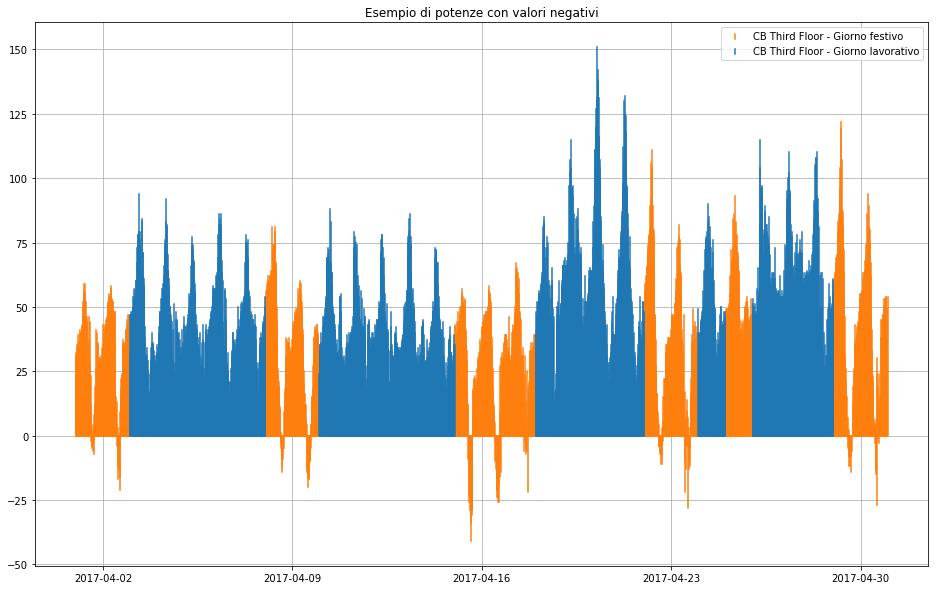

In [10]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2017]
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.month == 4]

curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

#ax.plot(curr_dataset.index, curr_dataset['holidays'], label='hol')

ax.grid()
ax.legend()
plt.title("Esempio di potenze con valori negativi", fontdict=None, loc='center', pad=None)
plt.show()

Questi dati anomali presentano alcune caratteristiche comuni:
- non compaiono mai nelle giornate lavorative.
- compaiono solo nella fascia oraria 10-17.
- compaiono principalmente nei mesi di primavera.


C:\ProgramData\Anaconda3\envs\digit\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


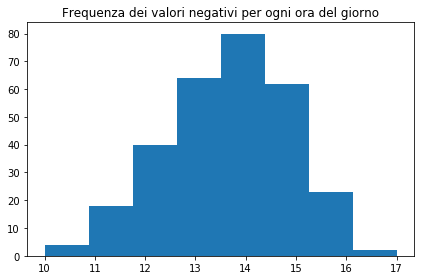

In [11]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
hours = train[train['AvgP3']<0]['DateTime'].dt.hour
ax.hist(hours, bins=len(hours.unique()))
plt.title("Frequenza dei valori negativi per ogni ora del giorno", fontdict=None, loc='center', pad=None)
plt.show()

Questi pattern portano ad ipotizzare che l'ufficio potrebbe essere dotato di pannelli fotovoltaici e i valori di potenza negativa potrebbero indicare che i consumi dell'edificio sono minori rispetto all'energia prodotta dai pannelli, come suggerito dal sito https://ctlsys.com/support/negative_power_values/:

" There are a few different reasons for negative power readings:

- One or more CTs are installed backwards. CTs have a label or arrow that should point towards the source of power (generally the transformer, breaker, or fuse).
- ***This is a bidirectional power measurement application, such as a photovoltaic system, where negative power occurs whenever you generate more power than you consume. In this case, there is nothing wrong with the negative power readings, so long as they occur when power is being generated.***
- The current transformers are installed so that the phases don’t match the voltage phases. For example, suppose the CTs are shifted by one phase, so that instead of monitoring phases A, B, and C (in that order), the CTs are on B, C, and A. This will generally result in negative power or a very low power factor. "

In conclusione si è scelto di considerare corretti questi valori.